In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import sys
sys.path.insert(0, '../')
import utilityfunctions as uf

## PCA Review

1. What does "PCA" stand for?
2. What does PCA *do*?
3. In what circumstances might you use PCA?

Today's notebook is a modification of https://charlesreid1.github.io/circe/Digit%20Classification%20-%20PCA.html

## Handwritten Digits Data Set

The data set we wil be analyzing is a well known data set for handwriting recognition from https://archive.ics.uci.edu/ml/datasets/optical+recognition+of+handwritten+digits.

__Take a look at the data__.

*The independent variables*: each data point (observation) is an 8 pixel by 8 pixel grayscale image. We flatten this so each data point is represented by a 64 floating point one dimensional array. 

*The dependent variable*: the label is the number in the image, 0 ... 9.

*Reason for using PCA*: if we can project from 64 dimensions down to some number less than 10, we can fit a regression (or other!) model more efficiently.

### Load and separate and examine the training data

In [2]:
# Let's load the training data
train = np.array(np.genfromtxt('../data/optdigits/optdigits.tra', delimiter=',', dtype=int))  
print(uf.getShapeType(train))

((3823, 65), dtype('int32'))


In [3]:
# Let's split off the labels
def split(data, ycol):
    y = data[:, ycol]
    xfirst = data[:, 0:ycol]
    xsecond = data[:, ycol+1:data.shape[1]]
    return (np.hstack((xfirst, xsecond)), y)

In [4]:
(x, y) = split(train, train.shape[1]-1)
print(uf.getShapeType(y))
print(uf.getShapeType(x))

((3823,), dtype('int32'))
((3823, 64), dtype('int32'))


[[ 0  0  0  3 11 16  0  0]
 [ 0  0  5 16 11 13  7  0]
 [ 0  3 15  8  1 15  6  0]
 [ 0 11 16 16 16 16 10  0]
 [ 0  1  4  4 13 10  2  0]
 [ 0  0  0  0 15  4  0  0]
 [ 0  0  0  3 16  0  0  0]
 [ 0  0  0  1 15  2  0  0]]


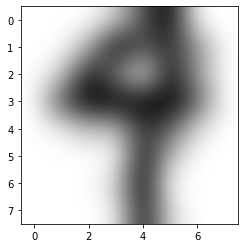

In [5]:
# Let's look at one of the observations
observation = x[3].reshape(8, 8)
print(observation)
plt.imshow(observation, cmap='gray_r', interpolation='bicubic')
plt.show()

### Normalize and center the data

In [6]:
# What's the optional preprocessing step before doing a PCA?

In [7]:
# What's the second, non-optional, preprocessing step for PCA?

# Let's center our data! 
def center(data):
    centered = data - np.mean(data, axis=0)
    return centered

In [8]:
# Let's preprocess our data! Note: if we minmaxed, then the data is not yet centered; if we zscored, the data is centered; if we didn't normalize at all, we don't know.
def preprocess(data, minmax=False, zScore=False):
    if minmax == True and zScore == True:
        print("Nope, won't do that!")
        return data
    elif minmax == True:
        data = uf.minmaxGlobal(data)
        return center(data)
    elif zScore == True:
        return uf.zScore(data)   

In [9]:
centered = preprocess(x, zScore=True)
print(uf.getShapeType(centered))

((3823, 64), dtype('float64'))


### Fit the PCA

In [10]:
# What's the first step in fitting a PCA?

# Let's get the covariance matrix!
def getCovariance(data):
    return (data.T @ data) / (data.shape[0] - 1)

In [11]:
covarianceMatrix = getCovariance(centered)

# What should its dimensions be?
print(uf.getShapeType(covarianceMatrix))

((64, 64), dtype('float64'))


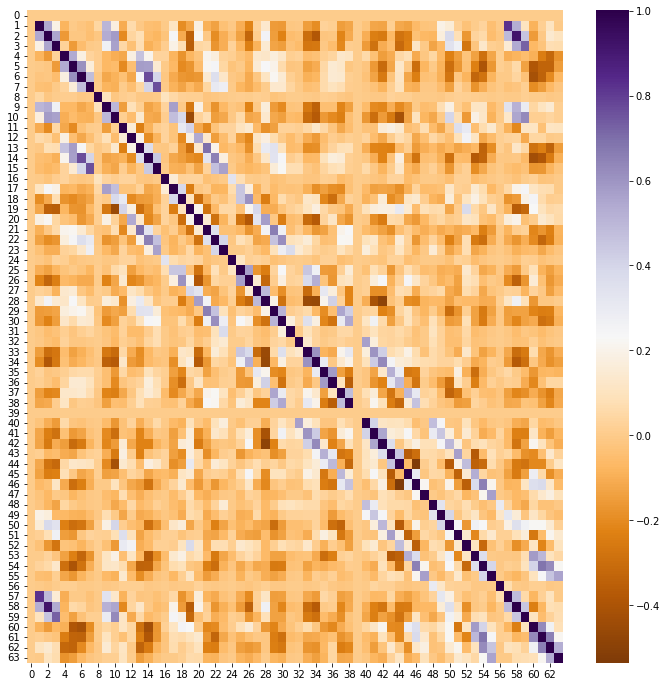

In [12]:
# Let's look at the covariance matrix
fig = plt.figure(figsize=(12,12))
sns.heatmap(pd.DataFrame(covarianceMatrix), annot=False, cmap='PuOr')
plt.show()

In [13]:
# What are the second and third steps in fitting a PCA?

def getSortedEigens(data):
    # Let's get the eigenvalues and eigenvectors!
    eigenvals, eigenvecs = np.linalg.eig(data)
    # Let's get an ordering over the eigenvalues!
    order = np.argsort(eigenvals)[::-1]
    # Let's sort the eigenvalues and eigenvectors accordingly
    eigenvalsSorted = eigenvals[order]
    eigenvecsSorted = eigenvecs[:, order]
    return eigenvalsSorted, eigenvecsSorted

In [14]:
eigenvals, eigenvecs = getSortedEigens(covarianceMatrix)
print(uf.getShapeType(eigenvals))
print(uf.getShapeType(eigenvecs))
# How is the eigenvector matrix arranged?

((64,), dtype('float64'))
((64, 64), dtype('float64'))


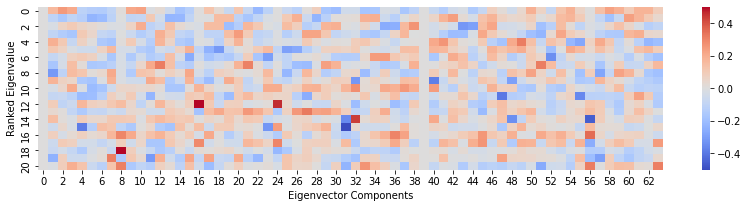

In [15]:
# We can visualize the eigenvectors, sorted by eigenvalue rank, and visually identify which eigenvector components dominate in each eigenvalue. This is essentially a visualization of what information the principal component analysis has judged most important.
fig = plt.figure(figsize=(14,3))
sns.heatmap(pd.DataFrame(eigenvecs[:, 0:21].T), 
            annot=False, cmap='coolwarm',
           vmin=-0.5,vmax=0.5)

plt.ylabel("Ranked Eigenvalue")
plt.xlabel("Eigenvector Components")
plt.show()

In [16]:
# What's the fourth step in fitting a PCA?

# Let's compute the proportional variance and the cumulative sum of the proportional variance!
def getVarianceStats(eigenvals):
    eigenvalsSum = np.sum(eigenvals)
    proportionalVariances = [eigenval / eigenvalsSum for eigenval in eigenvals]
    cumulativeSum = np.cumsum(proportionalVariances)
    return cumulativeSum, proportionalVariances

In [17]:
cumulativeSum, proportionalVariances = getVarianceStats(eigenvals)

### Scree and Elbow plots

These are two plots that will help you move beyond "just keep the eigenvalues that account for 90% of the variance".

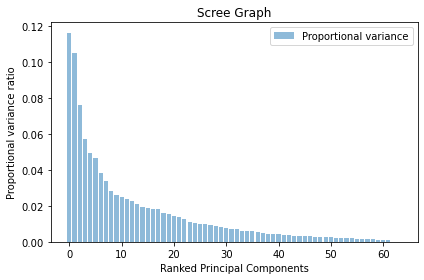

In [18]:
# Let's look at the proportional variance

plt.figure(figsize=(6, 4))

plt.bar(range(len(proportionalVariances)), proportionalVariances, alpha=0.5, align='center',
        label='Proportional variance')

plt.ylabel('Proportional variance ratio')
plt.xlabel('Ranked Principal Components')
plt.title("Scree Graph")

plt.legend(loc='best')
plt.tight_layout()

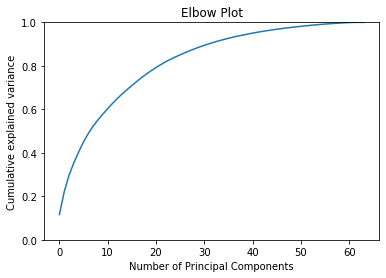

In [19]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)

ax1.plot(cumulativeSum)

ax1.set_ylim([0,1.0])

ax1.set_xlabel('Number of Principal Components')
ax1.set_ylabel('Cumulative explained variance')
ax1.set_title('Elbow Plot')

plt.show()

### Projecting the data

In [20]:
# Let's project the data into this PCA space
def project(data, eigenvectors, numberOfComponents):
    v = eigenvectors[:, 0:numberOfComponents]
    print(uf.getShapeType(v))
    projected = data@v
    return projected

In [21]:
# Looking at this elbow plot, how many principal components do you think we want to keep?

# Let's keep the top 10
projected = project(centered, eigenvecs, 10)
print(uf.getShapeType(projected))

((64, 10), dtype('float64'))
((3823, 10), dtype('float64'))


### What can we do with data in PCA space? 

* Look at it!
* Fit models!

It's kind of weird to use linear regression for this dataset. Linear regression is meant for data where the labels are quantitative ordinal. How do we know this?

Although the integers 0..9 are ordered, here they are just labels. But we don't (yet!) know any other type of model to fit. What to do? 

Let's make up some y's - let's set y to the sum of the values in each row. 

But, you say, that's just a regular linear function. 

*Indeed, say I*. But if I gave you that data and didn't tell you anything, you'd have to fit a model to find that out.

In [22]:
def makeRegressionY(data):
    y = np.array([np.sum(data[i]) for i in range(data.shape[0])])
    return y
yp = makeRegressionY(x)
print(yp.shape)

(3823,)


In [23]:
# Remember y? Let's fit a linear regression model to the projected data
# NB: In this context, it's kind of weird to use linear regression. Although the integers 0..9 are ordered, here they are just labels. But we don't (yet!) know any other type of model to fit.
def fit(projected, independent, y):
    projectedandy = np.hstack((projected, np.array([y]).T))
    print(uf.getShapeType(projectedandy))
    c = uf.fitlstsq(projectedandy, independent, projectedandy.shape[1]-1)
    return c

In [24]:
%%time
c = fit(projected, [0,1,2,3,4,5,6,7,8,9], yp)
print(c)

((3823, 11), dtype('float64'))
[ 3.15134188e+02  4.98313529e-01  2.62388732e-01  1.14633274e+00
  6.17753442e-01  2.66317289e+00 -1.86389388e+00 -1.35387101e+00
  4.58129005e+00  3.14195845e+00  2.23466680e+00]
Wall time: 5.33 ms


In [25]:
# Did you *look* at the data? We also have test! Let's test

In [26]:
# Let's load the test data
test = np.array(np.genfromtxt('../data/optdigits/optdigits.tes', delimiter=',', dtype=int))  
print(uf.getShapeType(test))
(xt, yt) = split(test, test.shape[1]-1)

# Make sure we preprocess the same way!
centeredt = preprocess(xt, zScore=True)
print(uf.getShapeType(centeredt))

# Why are we not calculating the PCA again?
projectedt = project(centeredt, eigenvecs, 10)
print(uf.getShapeType(projectedt))

((1797, 65), dtype('int32'))
((1797, 64), dtype('float64'))
((64, 10), dtype('float64'))
((1797, 10), dtype('float64'))


In [27]:
%%time
yhat = uf.predict(projectedt, [0,1,2,3,4,5,6,7,8,9], c)

Wall time: 1 ms


In [28]:
ypt = makeRegressionY(xt)
print(uf.getSummaryStatistics(ypt))
print(uf.rsquared(ypt, yhat))

             0
0   433.000000
1   185.000000
2   312.586533
3  1186.990425
0.08932377473687902


### Comparing PCA to not PCA

In [29]:
# Let's compare with a regression fit on the original data
# We will, but don't have to, normalize and center first
centered = preprocess(x, zScore=True)
print(uf.getShapeType(centered))

((3823, 64), dtype('float64'))


In [30]:
%%time
c1 = fit(centered, [x for x in range(centered.shape[1]-1)], yp)

((3823, 65), dtype('float64'))
Wall time: 8.76 ms


In [31]:
centeredt = preprocess(xt, zScore=True)
print(uf.getShapeType(centeredt))

((1797, 64), dtype('float64'))


In [32]:
%%time
yhat1 = uf.predict(centeredt, [x for x in range(centeredt.shape[1]-1)], c1)

Wall time: 4 ms


In [33]:
print(uf.rsquared(ypt, yhat1))

0.9913788882566076


## Resources

* https://www.displayr.com/8-tips-for-interpreting-r-squared/